In [1]:
import pandas as pd
import numpy as np
import os
import glob
from scipy.spatial import distance
import scipy.cluster.hierarchy as shc
from scipy.cluster.hierarchy import dendrogram, linkage

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

#import xgboost as xgb

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
prot_counts = pd.read_csv("prot_exp_final_all.csv", index_col=0)
prot_counts.head()

,TCGA-CJ-4903-01A,TCGA-CZ-5460-01A,TCGA-CJ-4899-01A,TCGA-CZ-5470-01A,TCGA-CJ-5671-01A,TCGA-A3-3370-01A,TCGA-CZ-5451-01A,TCGA-B0-5117-01A,TCGA-CW-5587-01A,TCGA-CZ-5455-01A,...,TCGA-BP-4981-01A,TCGA-CJ-4887-01A,TCGA-B0-5120-01A,TCGA-CJ-4894-01A,TCGA-B0-4703-01A,TCGA-B8-5162-01A,TCGA-BP-4965-01A,TCGA-CJ-4888-01A,TCGA-CW-5591-01A,TCGA-CJ-5672-01A
<mitochondria>,0.044754,0.875530,-0.894910,-0.060682,-0.312500,-0.111730,0.023625,1.536200,-0.134370,-0.297370,...,-0.236350,-0.015697,-0.933390,-0.269130,-0.510240,-0.483250,-0.240650,0.229210,0.079572,-0.249400
<poly(ADP-ribose)>,0.369868,1.826913,-1.286147,0.740998,-1.311549,-0.643529,-0.676716,-1.512748,-1.177063,-0.681278,...,-0.202327,-0.775015,-0.702468,-0.206928,-0.469325,-1.378053,-1.373476,-1.143337,0.402253,-1.377135
ABL1,0.036933,-0.140924,0.041607,-0.340989,0.074455,0.200099,0.020876,-0.088498,-0.177335,-0.064713,...,-0.013676,-0.154530,0.136553,0.046197,0.027029,-0.003654,0.027928,0.278226,-0.206860,-0.046963
ACACA/ACACB,-1.385200,-1.166825,-1.825600,-1.468250,-1.443350,-1.583400,-1.217200,0.080710,-1.543450,-1.229035,...,-1.429200,-0.851635,-1.866250,-1.649100,-1.274550,-1.555500,-1.546950,-1.080605,-1.180850,-1.315950
ACSL1,-0.166565,1.024545,-0.799764,1.273214,-0.576488,0.277816,0.615333,3.688568,0.204328,0.371815,...,0.585761,0.829382,-0.620210,-0.647126,-0.687568,-0.875571,-0.280623,-0.352903,0.261027,-0.190783


In [3]:
prot_counts = prot_counts.iloc[2:,:]
prot_counts.head()

,TCGA-CJ-4903-01A,TCGA-CZ-5460-01A,TCGA-CJ-4899-01A,TCGA-CZ-5470-01A,TCGA-CJ-5671-01A,TCGA-A3-3370-01A,TCGA-CZ-5451-01A,TCGA-B0-5117-01A,TCGA-CW-5587-01A,TCGA-CZ-5455-01A,...,TCGA-BP-4981-01A,TCGA-CJ-4887-01A,TCGA-B0-5120-01A,TCGA-CJ-4894-01A,TCGA-B0-4703-01A,TCGA-B8-5162-01A,TCGA-BP-4965-01A,TCGA-CJ-4888-01A,TCGA-CW-5591-01A,TCGA-CJ-5672-01A
ABL1,0.036933,-0.140924,0.041607,-0.340989,0.074455,0.200099,0.020876,-0.088498,-0.177335,-0.064713,...,-0.013676,-0.154530,0.136553,0.046197,0.027029,-0.003654,0.027928,0.278226,-0.206860,-0.046963
ACACA/ACACB,-1.385200,-1.166825,-1.825600,-1.468250,-1.443350,-1.583400,-1.217200,0.080710,-1.543450,-1.229035,...,-1.429200,-0.851635,-1.866250,-1.649100,-1.274550,-1.555500,-1.546950,-1.080605,-1.180850,-1.315950
ACSL1,-0.166565,1.024545,-0.799764,1.273214,-0.576488,0.277816,0.615333,3.688568,0.204328,0.371815,...,0.585761,0.829382,-0.620210,-0.647126,-0.687568,-0.875571,-0.280623,-0.352903,0.261027,-0.190783
ACSS2,0.472893,0.596004,-0.909490,0.286180,-0.754916,-0.249496,0.364830,0.819898,-0.162137,0.018552,...,0.126219,0.618701,-0.636101,-0.729348,-0.691819,-0.965223,-0.223543,-0.642816,0.815279,0.222168
ACTB,-0.296035,-0.268804,-0.146130,-0.310820,-0.052780,-0.193430,-0.483482,0.004655,-0.027606,-0.265044,...,-0.293911,-0.184101,-0.369350,-0.163824,0.210892,-0.335441,-0.502450,0.067153,-0.131868,-0.029485


In [4]:
## Read the labels dataset as pandas dataframe:
meta = pd.read_csv('data_clinical_patient.txt', sep="\t", header=0, skiprows=[0,1,2,3])
meta.head()

,OTHER_PATIENT_ID,PATIENT_ID,FORM_COMPLETION_DATE,HISTOLOGICAL_DIAGNOSIS,GRADE,LATERALITY,PROSPECTIVE_COLLECTION,RETROSPECTIVE_COLLECTION,SEX,RACE,...,INFORMED_CONSENT_VERIFIED,PROJECT_CODE,STAGE_OTHER,TARGETED_MOLECULAR_THERAPY,TISSUE_SOURCE_SITE,SITE_OF_TUMOR_TISSUE,OS_STATUS,OS_MONTHS,DFS_STATUS,DFS_MONTHS
0,2B1DEA0A-6D55-4FDD-9C1C-0D9FBE03BD78,TCGA-3Z-A93Z,2014-11-11,Kidney Clear Cell Renal Carcinoma,G2,Right,YES,NO,MALE,BLACK OR AFRICAN AMERICAN,...,YES,[Not Available],[Not Available],NO,3Z,Kidney,0:LIVING,12.65,0:DiseaseFree,12.65
1,D3B47E53-6F40-4FC8-B5A4-CBE548A770A9,TCGA-6D-AA2E,3/17/14,Kidney Clear Cell Renal Carcinoma,G2,Right,YES,NO,Female,BLACK OR AFRICAN AMERICAN,...,YES,[Not Available],[Not Available],NO,6D,Kidney,0:LIVING,11.89,0:DiseaseFree,11.89
2,9fb55e0b-43d8-40a3-8ef2-d198e6290551,TCGA-A3-3306,8/23/10,Kidney Clear Cell Renal Carcinoma,G3,Left,NO,YES,Male,WHITE,...,YES,[Not Available],[Not Available],[Not Available],A3,Kidney,0:LIVING,36.79,0:DiseaseFree,36.79
3,7ac1d6c6-9ade-49af-8794-10b5b96b2b05,TCGA-A3-3307,4/13/10,Kidney Clear Cell Renal Carcinoma,G3,Right,NO,YES,Male,[Not Available],...,YES,[Not Available],[Not Available],[Not Available],A3,Kidney,0:LIVING,47.17,0:DiseaseFree,47.17
4,3cbca837-f5a7-4a87-8f02-c59eac232d5a,TCGA-A3-3308,4/12/10,Kidney Clear Cell Renal Carcinoma,G2,Right,NO,YES,Female,WHITE,...,YES,[Not Available],[Not Available],[Not Available],A3,Kidney,0:LIVING,0.53,0:DiseaseFree,0.53


In [5]:
prot_counts.columns = [i[:12] for i in prot_counts.columns]
prot_counts.columns


Index(['TCGA-CJ-4903', 'TCGA-CZ-5460', 'TCGA-CJ-4899', 'TCGA-CZ-5470',
       'TCGA-CJ-5671', 'TCGA-A3-3370', 'TCGA-CZ-5451', 'TCGA-B0-5117',
       'TCGA-CW-5587', 'TCGA-CZ-5455',
       ...
       'TCGA-BP-4981', 'TCGA-CJ-4887', 'TCGA-B0-5120', 'TCGA-CJ-4894',
       'TCGA-B0-4703', 'TCGA-B8-5162', 'TCGA-BP-4965', 'TCGA-CJ-4888',
       'TCGA-CW-5591', 'TCGA-CJ-5672'],
      dtype='object', length=230)

In [6]:
prot_counts.head()

,TCGA-CJ-4903,TCGA-CZ-5460,TCGA-CJ-4899,TCGA-CZ-5470,TCGA-CJ-5671,TCGA-A3-3370,TCGA-CZ-5451,TCGA-B0-5117,TCGA-CW-5587,TCGA-CZ-5455,...,TCGA-BP-4981,TCGA-CJ-4887,TCGA-B0-5120,TCGA-CJ-4894,TCGA-B0-4703,TCGA-B8-5162,TCGA-BP-4965,TCGA-CJ-4888,TCGA-CW-5591,TCGA-CJ-5672
ABL1,0.036933,-0.140924,0.041607,-0.340989,0.074455,0.200099,0.020876,-0.088498,-0.177335,-0.064713,...,-0.013676,-0.154530,0.136553,0.046197,0.027029,-0.003654,0.027928,0.278226,-0.206860,-0.046963
ACACA/ACACB,-1.385200,-1.166825,-1.825600,-1.468250,-1.443350,-1.583400,-1.217200,0.080710,-1.543450,-1.229035,...,-1.429200,-0.851635,-1.866250,-1.649100,-1.274550,-1.555500,-1.546950,-1.080605,-1.180850,-1.315950
ACSL1,-0.166565,1.024545,-0.799764,1.273214,-0.576488,0.277816,0.615333,3.688568,0.204328,0.371815,...,0.585761,0.829382,-0.620210,-0.647126,-0.687568,-0.875571,-0.280623,-0.352903,0.261027,-0.190783
ACSS2,0.472893,0.596004,-0.909490,0.286180,-0.754916,-0.249496,0.364830,0.819898,-0.162137,0.018552,...,0.126219,0.618701,-0.636101,-0.729348,-0.691819,-0.965223,-0.223543,-0.642816,0.815279,0.222168
ACTB,-0.296035,-0.268804,-0.146130,-0.310820,-0.052780,-0.193430,-0.483482,0.004655,-0.027606,-0.265044,...,-0.293911,-0.184101,-0.369350,-0.163824,0.210892,-0.335441,-0.502450,0.067153,-0.131868,-0.029485


In [7]:
prot_counts = prot_counts.loc[:,~prot_counts.columns.duplicated()]
prot_counts.shape

(396, 230)

In [8]:
prot_cts = prot_counts.T
prot_cts.head()

,ABL1,ACACA/ACACB,ACSL1,ACSS2,ACTB,ACVRL1,ADAR,AKT1/AKT2/AKT3,AKT1S1,AKT2,...,XRCC5,YAP1,YBX1,YTHDF2,YTHDF3,YWHAB,YWHAE,YWHAZ,ZAP70,ZEB1
TCGA-CJ-4903,0.036933,-1.385200,-0.166565,0.472893,-0.296035,0.595880,-0.56584,-0.109278,0.144617,0.783073,...,-0.48049,0.133776,-0.171970,-0.431221,-0.681187,0.025505,0.023668,-0.55658,-0.031723,0.151147
TCGA-CZ-5460,-0.140924,-1.166825,1.024545,0.596004,-0.268804,1.018000,-0.41205,0.262781,0.240054,0.195186,...,-0.70017,0.053388,-0.165055,-0.167590,-0.203581,0.176460,-0.087255,-0.22760,0.077279,-0.468068
TCGA-CJ-4899,0.041607,-1.825600,-0.799764,-0.909490,-0.146130,0.322570,-0.72058,0.453309,-0.006024,0.607381,...,-0.82787,0.496430,-0.327107,-0.541725,-0.704579,0.136970,0.176280,-0.38394,-0.056803,0.300013
TCGA-CZ-5470,-0.340989,-1.468250,1.273214,0.286180,-0.310820,-0.157750,-0.46625,-0.137995,0.007065,0.117839,...,0.13746,0.324063,0.068934,0.185386,0.506505,-0.012724,0.276640,-0.27982,0.160061,-0.539635
TCGA-CJ-5671,0.074455,-1.443350,-0.576488,-0.754916,-0.052780,0.049952,-0.55084,-0.146137,0.091930,0.285598,...,-0.38187,0.425590,0.324130,-0.416930,-0.377765,0.143050,0.241260,-0.27049,0.820165,-0.198694


In [9]:
meta.set_index("PATIENT_ID", inplace=True)
meta.head()

,OTHER_PATIENT_ID,FORM_COMPLETION_DATE,HISTOLOGICAL_DIAGNOSIS,GRADE,LATERALITY,PROSPECTIVE_COLLECTION,RETROSPECTIVE_COLLECTION,SEX,RACE,ETHNICITY,...,INFORMED_CONSENT_VERIFIED,PROJECT_CODE,STAGE_OTHER,TARGETED_MOLECULAR_THERAPY,TISSUE_SOURCE_SITE,SITE_OF_TUMOR_TISSUE,OS_STATUS,OS_MONTHS,DFS_STATUS,DFS_MONTHS
PATIENT_ID,,,,,,,,,,,,,,,,,,,,,
TCGA-3Z-A93Z,2B1DEA0A-6D55-4FDD-9C1C-0D9FBE03BD78,2014-11-11,Kidney Clear Cell Renal Carcinoma,G2,Right,YES,NO,MALE,BLACK OR AFRICAN AMERICAN,NOT HISPANIC OR LATINO,...,YES,[Not Available],[Not Available],NO,3Z,Kidney,0:LIVING,12.65,0:DiseaseFree,12.65
TCGA-6D-AA2E,D3B47E53-6F40-4FC8-B5A4-CBE548A770A9,3/17/14,Kidney Clear Cell Renal Carcinoma,G2,Right,YES,NO,Female,BLACK OR AFRICAN AMERICAN,NOT HISPANIC OR LATINO,...,YES,[Not Available],[Not Available],NO,6D,Kidney,0:LIVING,11.89,0:DiseaseFree,11.89
TCGA-A3-3306,9fb55e0b-43d8-40a3-8ef2-d198e6290551,8/23/10,Kidney Clear Cell Renal Carcinoma,G3,Left,NO,YES,Male,WHITE,NOT HISPANIC OR LATINO,...,YES,[Not Available],[Not Available],[Not Available],A3,Kidney,0:LIVING,36.79,0:DiseaseFree,36.79
TCGA-A3-3307,7ac1d6c6-9ade-49af-8794-10b5b96b2b05,4/13/10,Kidney Clear Cell Renal Carcinoma,G3,Right,NO,YES,Male,[Not Available],[Not Available],...,YES,[Not Available],[Not Available],[Not Available],A3,Kidney,0:LIVING,47.17,0:DiseaseFree,47.17
TCGA-A3-3308,3cbca837-f5a7-4a87-8f02-c59eac232d5a,4/12/10,Kidney Clear Cell Renal Carcinoma,G2,Right,NO,YES,Female,WHITE,[Not Available],...,YES,[Not Available],[Not Available],[Not Available],A3,Kidney,0:LIVING,0.53,0:DiseaseFree,0.53


In [10]:
meta2 = meta.loc[prot_cts.index]
#mir_cts2 = mir_cts.loc[meta2.index]

sum(prot_cts.index == meta2.index)

230

In [12]:
#meta2 = pd.concat([meta2, meta2.iloc[:, -5:]], axis=1)
meta2.head()

,OTHER_PATIENT_ID,FORM_COMPLETION_DATE,HISTOLOGICAL_DIAGNOSIS,GRADE,LATERALITY,PROSPECTIVE_COLLECTION,RETROSPECTIVE_COLLECTION,SEX,RACE,ETHNICITY,...,INFORMED_CONSENT_VERIFIED,PROJECT_CODE,STAGE_OTHER,TARGETED_MOLECULAR_THERAPY,TISSUE_SOURCE_SITE,SITE_OF_TUMOR_TISSUE,OS_STATUS,OS_MONTHS,DFS_STATUS,DFS_MONTHS
TCGA-CJ-4903,692f9978-ada8-43aa-81a1-108464c81609,2/3/11,Kidney Clear Cell Renal Carcinoma,G3,Left,NO,YES,Male,WHITE,NOT HISPANIC OR LATINO,...,YES,[Not Available],[Not Available],[Not Available],CJ,Kidney,0:LIVING,51.25,0:DiseaseFree,51.25
TCGA-CZ-5460,a7ddd737-714d-423f-8fb5-5a932d014487,3/11/11,Kidney Clear Cell Renal Carcinoma,G2,Right,NO,YES,Male,WHITE,NOT HISPANIC OR LATINO,...,YES,[Not Available],[Not Available],[Not Available],CZ,Kidney,0:LIVING,94.38,0:DiseaseFree,94.38
TCGA-CJ-4899,900b5f21-e8fb-4a3f-b8e3-ef098716e508,1/24/11,Kidney Clear Cell Renal Carcinoma,G2,Left,NO,YES,Male,ASIAN,NOT HISPANIC OR LATINO,...,YES,[Not Available],[Not Available],[Not Available],CJ,Kidney,0:LIVING,50.20,0:DiseaseFree,50.2
TCGA-CZ-5470,99f59583-2728-4c1d-b98c-8fbc3bb0a819,3/11/11,Kidney Clear Cell Renal Carcinoma,G3,Left,NO,YES,Female,[Not Available],[Not Available],...,YES,[Not Available],[Not Available],[Not Available],CZ,Kidney,0:LIVING,12.68,0:DiseaseFree,12.68
TCGA-CJ-5671,960d1eaf-0b96-488b-b62c-829c024fd4b8,4/22/11,Kidney Clear Cell Renal Carcinoma,G3,Left,NO,YES,Male,WHITE,NOT HISPANIC OR LATINO,...,YES,[Not Available],[Not Available],[Not Available],CJ,Kidney,0:LIVING,130.98,0:DiseaseFree,130.98


In [11]:
meta2.DFS_STATUS.value_counts()

DFS_STATUS
0:DiseaseFree            124
1:Recurred/Progressed     61
[Not Available]           45
Name: count, dtype: int64

In [12]:
meta2 = meta2[meta2.DFS_STATUS!="[Not Available]"]
meta2

,OTHER_PATIENT_ID,FORM_COMPLETION_DATE,HISTOLOGICAL_DIAGNOSIS,GRADE,LATERALITY,PROSPECTIVE_COLLECTION,RETROSPECTIVE_COLLECTION,SEX,RACE,ETHNICITY,...,INFORMED_CONSENT_VERIFIED,PROJECT_CODE,STAGE_OTHER,TARGETED_MOLECULAR_THERAPY,TISSUE_SOURCE_SITE,SITE_OF_TUMOR_TISSUE,OS_STATUS,OS_MONTHS,DFS_STATUS,DFS_MONTHS
TCGA-CJ-4903,692f9978-ada8-43aa-81a1-108464c81609,2/3/11,Kidney Clear Cell Renal Carcinoma,G3,Left,NO,YES,Male,WHITE,NOT HISPANIC OR LATINO,...,YES,[Not Available],[Not Available],[Not Available],CJ,Kidney,0:LIVING,51.25,0:DiseaseFree,51.25
TCGA-CZ-5460,a7ddd737-714d-423f-8fb5-5a932d014487,3/11/11,Kidney Clear Cell Renal Carcinoma,G2,Right,NO,YES,Male,WHITE,NOT HISPANIC OR LATINO,...,YES,[Not Available],[Not Available],[Not Available],CZ,Kidney,0:LIVING,94.38,0:DiseaseFree,94.38
TCGA-CJ-4899,900b5f21-e8fb-4a3f-b8e3-ef098716e508,1/24/11,Kidney Clear Cell Renal Carcinoma,G2,Left,NO,YES,Male,ASIAN,NOT HISPANIC OR LATINO,...,YES,[Not Available],[Not Available],[Not Available],CJ,Kidney,0:LIVING,50.20,0:DiseaseFree,50.2
TCGA-CZ-5470,99f59583-2728-4c1d-b98c-8fbc3bb0a819,3/11/11,Kidney Clear Cell Renal Carcinoma,G3,Left,NO,YES,Female,[Not Available],[Not Available],...,YES,[Not Available],[Not Available],[Not Available],CZ,Kidney,0:LIVING,12.68,0:DiseaseFree,12.68
TCGA-CJ-5671,960d1eaf-0b96-488b-b62c-829c024fd4b8,4/22/11,Kidney Clear Cell Renal Carcinoma,G3,Left,NO,YES,Male,WHITE,NOT HISPANIC OR LATINO,...,YES,[Not Available],[Not Available],[Not Available],CJ,Kidney,0:LIVING,130.98,0:DiseaseFree,130.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-CJ-4894,d1e4f4c0-08cc-4012-9372-9ab987d80dab,1/24/11,Kidney Clear Cell Renal Carcinoma,G3,Left,NO,YES,Male,WHITE,NOT HISPANIC OR LATINO,...,YES,[Not Available],[Not Available],[Not Available],CJ,Kidney,1:DECEASED,27.63,1:Recurred/Progressed,5.19
TCGA-B8-5162,d62d39f9-c896-4758-a785-e236f0154f14,5/26/11,Kidney Clear Cell Renal Carcinoma,G2,Left,YES,NO,Male,WHITE,NOT HISPANIC OR LATINO,...,YES,[Not Available],[Not Available],[Not Available],B8,Kidney,0:LIVING,1.18,0:DiseaseFree,1.18
TCGA-BP-4965,ec6aa756-c875-49f5-89e4-365b3f18b589,1/12/11,Kidney Clear Cell Renal Carcinoma,G2,Left,NO,YES,Male,WHITE,[Not Available],...,YES,[Not Available],[Not Available],[Not Available],BP,Kidney,0:LIVING,61.47,0:DiseaseFree,61.47
TCGA-CJ-4888,f2fca062-ca87-4089-916d-49b9ff146797,1/24/11,Kidney Clear Cell Renal Carcinoma,G4,Left,NO,YES,Male,WHITE,NOT HISPANIC OR LATINO,...,YES,[Not Available],[Not Available],[Not Available],CJ,Kidney,1:DECEASED,51.48,1:Recurred/Progressed,19.97


In [13]:
prot_cts = prot_cts.loc[meta2.index]
prot_cts.shape

(185, 396)

In [14]:
meta2.DFS_STATUS.value_counts()

DFS_STATUS
0:DiseaseFree            124
1:Recurred/Progressed     61
Name: count, dtype: int64

In [17]:
prot_cts.info()

<class 'pandas.core.frame.DataFrame'>
Index: 185 entries, TCGA-CJ-4903 to TCGA-CW-5591
Columns: 396 entries, ABL1 to ZEB1
dtypes: float64(396)
memory usage: 573.8+ KB


In [18]:
prot_cts.describe()

,ABL1,ACACA/ACACB,ACSL1,ACSS2,ACTB,ACVRL1,ADAR,AKT1/AKT2/AKT3,AKT1S1,AKT2,...,XRCC5,YAP1,YBX1,YTHDF2,YTHDF3,YWHAB,YWHAE,YWHAZ,ZAP70,ZEB1
count,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,...,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000
mean,0.006037,-1.260788,-0.030611,-0.119967,-0.188517,0.354175,-0.569771,0.227147,0.199655,0.466639,...,-0.766114,0.243198,-0.158797,-0.321391,-0.338880,0.089391,0.068926,-0.247819,-0.007641,-0.039803
std,0.145398,0.427309,0.623330,0.541765,0.202594,0.270576,0.146422,0.406941,0.333620,0.339599,...,0.293240,0.296055,0.237047,0.259640,0.366269,0.267644,0.107532,0.291450,0.474554,0.210283
min,-0.341253,-2.246500,-1.254911,-1.734005,-0.688720,-0.194770,-1.146600,-0.677147,-0.431299,-0.154496,...,-1.481600,-0.430435,-0.841070,-1.048996,-1.266340,-0.195740,-0.205250,-0.747100,-1.226051,-0.539635
25%,-0.088498,-1.548100,-0.450316,-0.461118,-0.320965,0.175970,-0.645000,-0.050632,0.004177,0.232018,...,-0.933770,0.031045,-0.320675,-0.485009,-0.616535,-0.007950,0.002426,-0.411680,-0.322258,-0.166513
50%,-0.015005,-1.311400,-0.082128,-0.180715,-0.192332,0.306200,-0.560470,0.163564,0.144667,0.440103,...,-0.737390,0.210820,-0.166768,-0.310082,-0.347062,0.057156,0.068812,-0.284720,-0.031723,-0.055675
75%,0.088270,-1.041895,0.354035,0.233157,-0.060980,0.481650,-0.489870,0.447384,0.317285,0.607381,...,-0.565800,0.426887,-0.027235,-0.143045,-0.119112,0.135850,0.124590,-0.167660,0.272037,0.063067
max,0.530727,0.172966,3.688568,1.709693,0.452400,1.259400,-0.122950,1.792324,1.897944,2.096354,...,0.137460,1.541040,0.630331,0.236475,0.779326,2.555100,0.409920,1.833200,1.703730,0.937831


In [15]:
no_recur = meta2[meta2["DFS_STATUS"]=="0:DiseaseFree"]
recur = meta2[meta2["DFS_STATUS"]=="1:Recurred/Progressed"]

print(no_recur.shape)
print(recur.shape)

(124, 59)
(61, 59)


In [16]:
pca = PCA()
pca.fit_transform(prot_cts)
pca

PCA()

74  components explain around 95% of the variance. From 309 mirs to  74


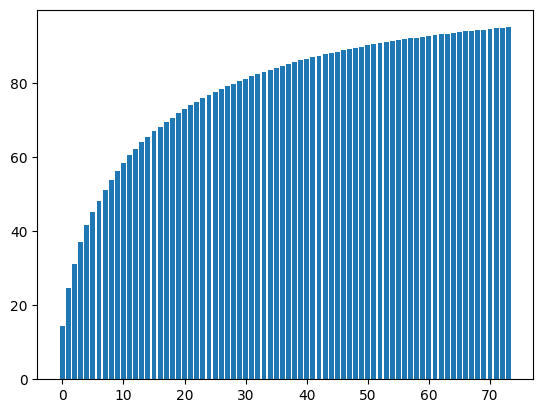

In [17]:
#explained_variance = np.var(pca, axis=0)
#explained_variance_ratio = explained_variance / np.sum(explained_variance)

total = sum(pca.explained_variance_)
k = 0
current_variance = 0
while current_variance/total < 0.95:
    current_variance += pca.explained_variance_[k]
    k = k + 1
    
print(k, " components explain around 95% of the variance. From 309 mirs to ", k)

pca = PCA(n_components=k)
prot_cts.pca = pca.fit(prot_cts)
prot_cts_pca = pca.transform(prot_cts)
#X_test_pca = pca.transform(X_test)

var_exp = pca.explained_variance_ratio_.cumsum()
var_exp = var_exp*100
plt.bar(range(k), var_exp);

In [18]:
X = prot_cts
y = meta2["DFS_STATUS"]
y = y.replace({'0:DiseaseFree':0,'1:Recurred/Progressed':1})
labels = ['0:DiseaseFree', '1:Recurred/Progressed']
#y.replace(to_replace=['Solid Tissue Normal', 'Primary Tumor'], value=[0,1],inplace=True)
y.value_counts()

DFS_STATUS
0    124
1     61
Name: count, dtype: int64

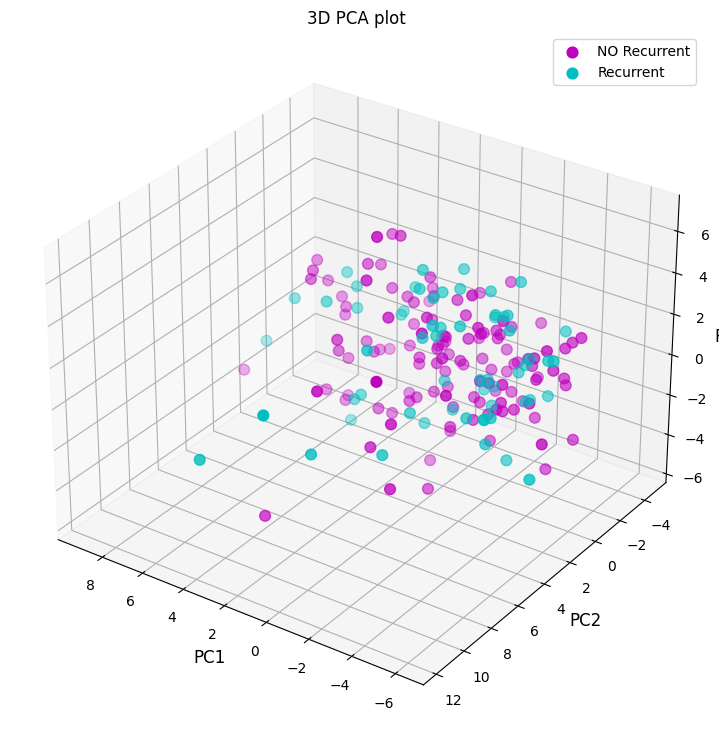

In [19]:
pca3 = PCA(n_components=3).fit(X)
X_reduced = pca3.transform(X)
Xax = X_reduced[:,0]
Yax = X_reduced[:,1]
Zax = X_reduced[:,2]

cdict = {0:'m',1:'c'}
label = {0:'NO Recurrent',1:'Recurrent'}

fig = plt.figure(figsize=(14,9))
ax = fig.add_subplot(111, 
                     projection='3d')
 
for l in np.unique(y):
 ix=np.where(y==l)
 ax.scatter(Xax[ix], 
            Yax[ix], 
            Zax[ix], 
            c=cdict[l], 
            s=60,
           label=label[l])
 
ax.set_xlabel("PC1", 
              fontsize=12)
ax.set_ylabel("PC2", 
              fontsize=12)
ax.set_zlabel("PC3", 
              fontsize=12)
 
ax.view_init(30, 125)
ax.legend()
plt.title("3D PCA plot")
plt.show()

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(y_train.value_counts())
print(y_test.value_counts())

(148, 396)
(148,)
(37, 396)
(37,)
DFS_STATUS
0    99
1    49
Name: count, dtype: int64
DFS_STATUS
0    25
1    12
Name: count, dtype: int64


GaussianNB
accuracy 0.7
f1 score 0.52
ROC AUC 0.65
PR AUC 0.43


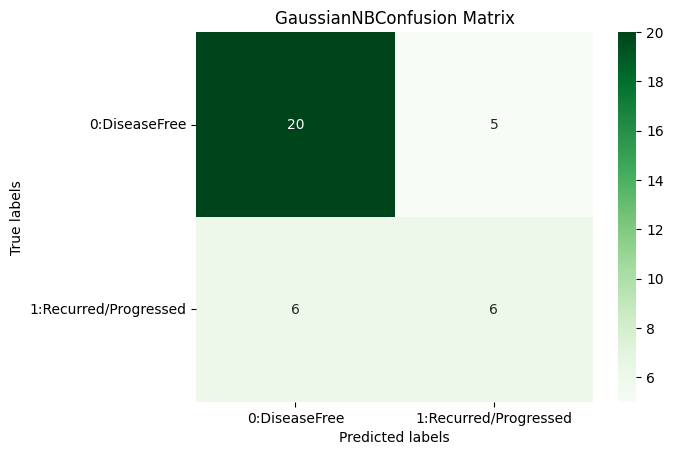

RandomForestClassifier
accuracy 0.68
f1 score 0.0
ROC AUC 0.5
PR AUC 0.32


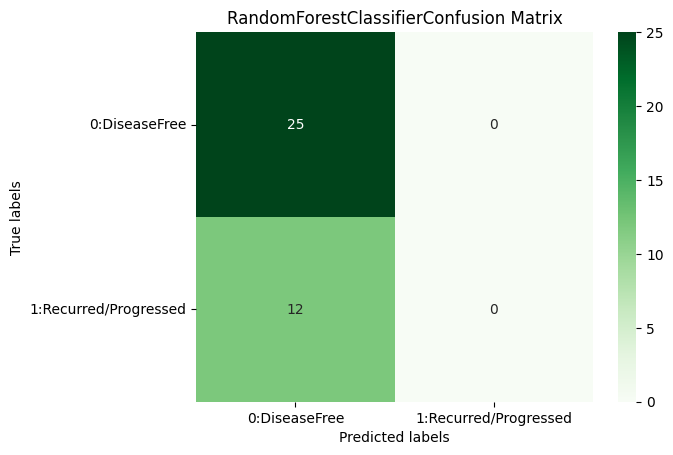

LogisticRegression
accuracy 0.49
f1 score 0.24
ROC AUC 0.42
PR AUC 0.3


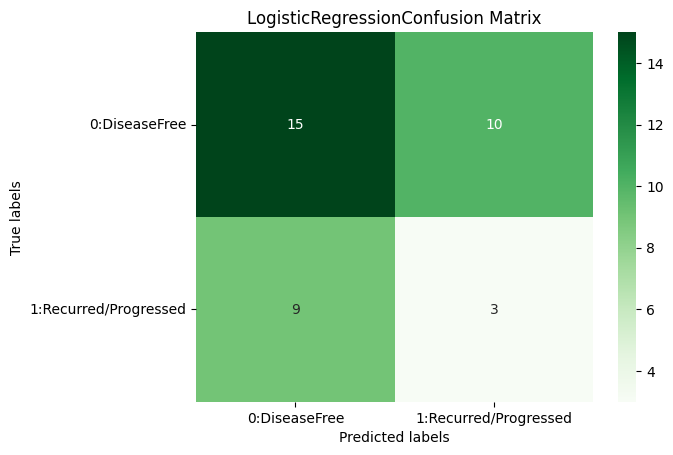

KNeighborsClassifier
accuracy 0.73
f1 score 0.29
ROC AUC 0.58
PR AUC 0.44


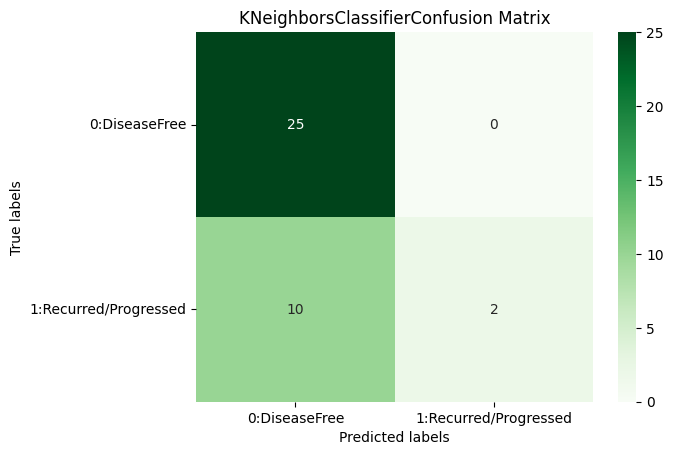

SVC
accuracy 0.73
f1 score 0.29
ROC AUC 0.58
PR AUC 0.44


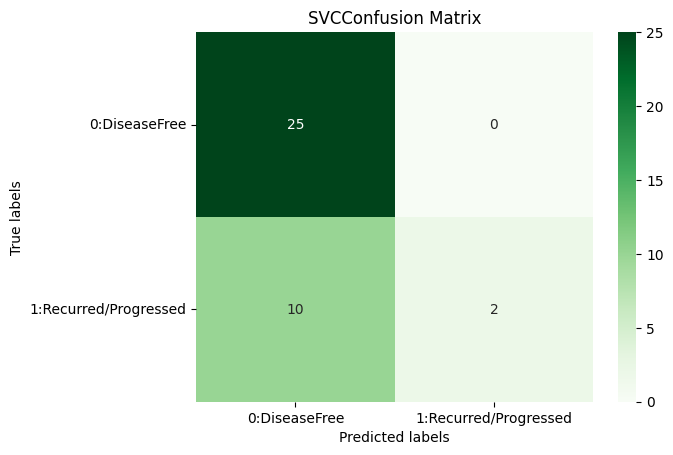

In [24]:
import seaborn as sns
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn import model_selection
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, f1_score, accuracy_score, roc_auc_score, average_precision_score, matthews_corrcoef
import xgboost as xgb

# three model variables with middle parameters as possible
clf1 = GaussianNB()
clf2 = RandomForestClassifier(random_state=0, n_jobs=10, n_estimators=500, class_weight="balanced")
clf3 = LogisticRegression(max_iter=1000, C=0.001,class_weight="balanced")
clf4 = KNeighborsClassifier(n_neighbors=25)
clf5 = SVC(kernel='poly', degree=2)
#clf6 = xgb.XGBClassifier()


models =[clf1, clf2, clf3, clf4, clf5]

# use of 5 quality metrics to be used in k fold cross validation
scoring = {'acc' : make_scorer(accuracy_score),
           'f1' : make_scorer(f1_score), 
           'roc_auc' : make_scorer(roc_auc_score),
           'PR_auc' : make_scorer(average_precision_score),
           'matcf': make_scorer(matthews_corrcoef)}

# loop through the three models and fit all X, y and evaluate the model using 5 kfold cross validation
# and store each type of score range in a list then store total scores for each model in a dictionary
score = []
for clf in models:
    # Fine-tune the hyperparameters
    clf.fit(X_train, y_train)

    # Make predictions using the optimised parameters
    clf_pred = clf.predict(X_test)

    print(clf.__class__.__name__)
    print("accuracy", round(accuracy_score(y_test, clf_pred), 2))
    print("f1 score", round(f1_score(y_test, clf_pred), 2))
    print("ROC AUC", round(roc_auc_score(y_test, clf_pred), 2))
    print("PR AUC", round(average_precision_score(y_test, clf_pred), 2))
    
    score.append(round(average_precision_score(y_test, clf_pred), 2))
    cm = confusion_matrix(y_test, clf_pred)

    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, fmt='g', cmap='Greens') 

    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels') 
    ax.set_title(str(clf.__class__.__name__) + 'Confusion Matrix') 
    ax.xaxis.set_ticklabels(labels) 
    ax.yaxis.set_ticklabels(labels, rotation=360);
    plt.show()
    

In [25]:
# initiation of the model with the best score
#from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state=0, n_jobs=10, n_estimators=500, class_weight="balanced")

# fit the model on the training data
clf.fit(X, y)


RandomForestClassifier(class_weight='balanced', n_estimators=500, n_jobs=10,
                       random_state=0)

In [27]:
import time


start_time = time.time()
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.158 seconds


In [28]:
forest_importances = pd.Series(importances, index=X.columns)
importances = pd.DataFrame(forest_importances, columns=["value"])
#fig, ax = plt.subplots()
#forest_importances.plot.bar(yerr=std, ax=ax)
#ax.set_title("Feature importances using MDI")
#ax.set_ylabel("Mean decrease in impurity")
#fig.tight_layout()
sort = importances.sort_values(by=["value"], ascending=False)
import_p = sort.iloc[:20,]


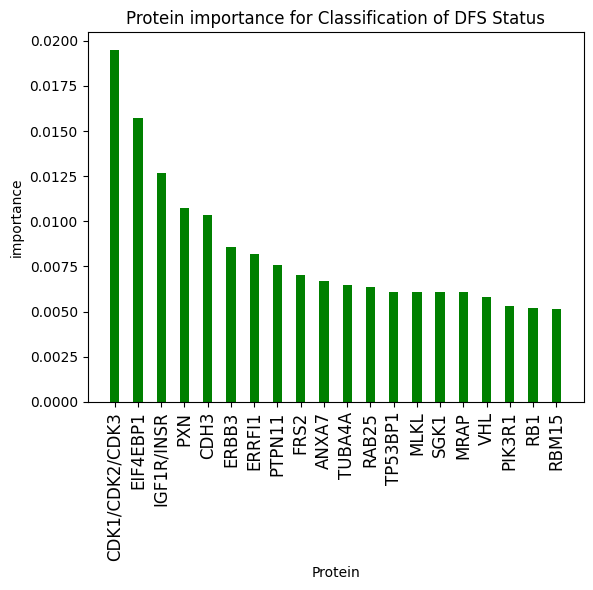

In [29]:
plt.bar(import_p.index, import_p["value"], color ='green',
        width = 0.4)
plt.xticks(fontsize=12, rotation=90)
plt.xlabel("Protein")
plt.ylabel("importance")
plt.title("Protein importance for Classification of DFS Status")
plt.show()

In [30]:
prot_total = pd.concat([X, meta2["DFS_STATUS"]], axis=1)
prot_total.head()

,ABL1,ACACA/ACACB,ACSL1,ACSS2,ACTB,ACVRL1,ADAR,AKT1/AKT2/AKT3,AKT1S1,AKT2,...,YAP1,YBX1,YTHDF2,YTHDF3,YWHAB,YWHAE,YWHAZ,ZAP70,ZEB1,DFS_STATUS
TCGA-CJ-4903,0.036933,-1.385200,-0.166565,0.472893,-0.296035,0.595880,-0.56584,-0.109278,0.144617,0.783073,...,0.133776,-0.171970,-0.431221,-0.681187,0.025505,0.023668,-0.55658,-0.031723,0.151147,0:DiseaseFree
TCGA-CZ-5460,-0.140924,-1.166825,1.024545,0.596004,-0.268804,1.018000,-0.41205,0.262781,0.240054,0.195186,...,0.053388,-0.165055,-0.167590,-0.203581,0.176460,-0.087255,-0.22760,0.077279,-0.468068,0:DiseaseFree
TCGA-CJ-4899,0.041607,-1.825600,-0.799764,-0.909490,-0.146130,0.322570,-0.72058,0.453309,-0.006024,0.607381,...,0.496430,-0.327107,-0.541725,-0.704579,0.136970,0.176280,-0.38394,-0.056803,0.300013,0:DiseaseFree
TCGA-CZ-5470,-0.340989,-1.468250,1.273214,0.286180,-0.310820,-0.157750,-0.46625,-0.137995,0.007065,0.117839,...,0.324063,0.068934,0.185386,0.506505,-0.012724,0.276640,-0.27982,0.160061,-0.539635,0:DiseaseFree
TCGA-CJ-5671,0.074455,-1.443350,-0.576488,-0.754916,-0.052780,0.049952,-0.55084,-0.146137,0.091930,0.285598,...,0.425590,0.324130,-0.416930,-0.377765,0.143050,0.241260,-0.27049,0.820165,-0.198694,0:DiseaseFree


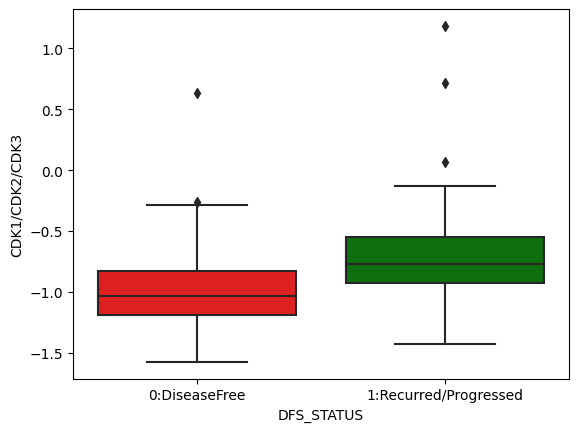

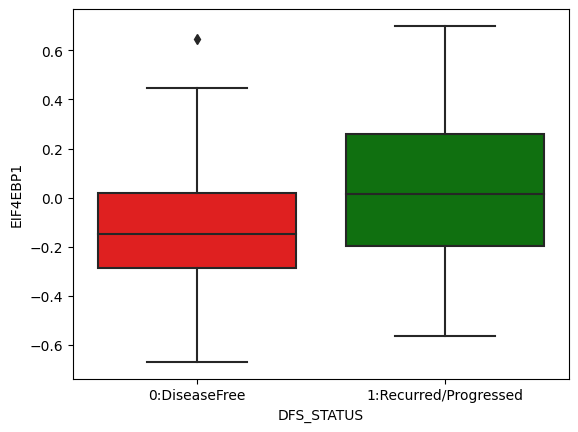

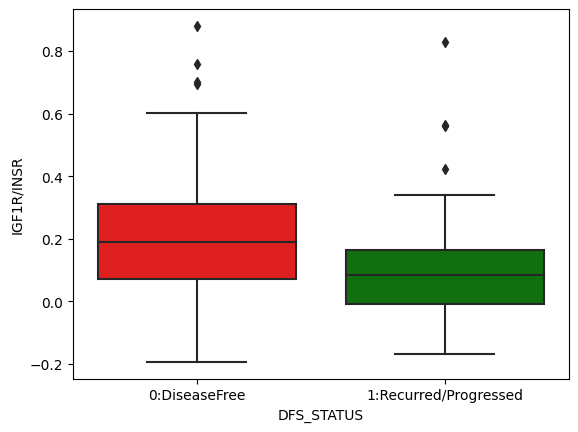

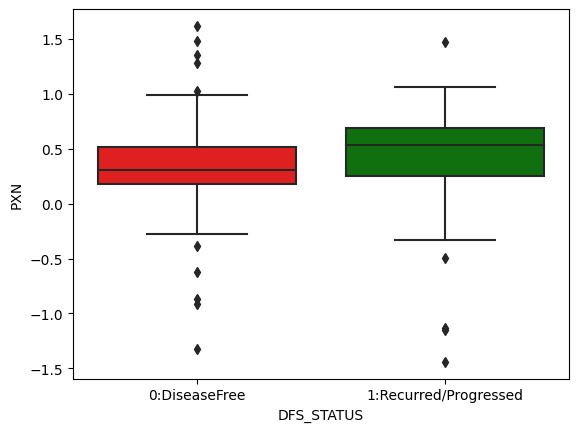

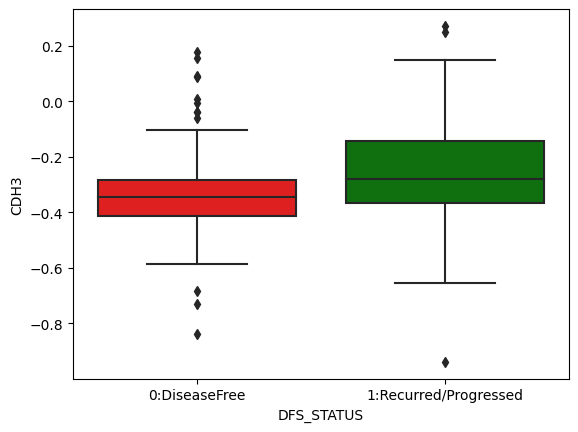

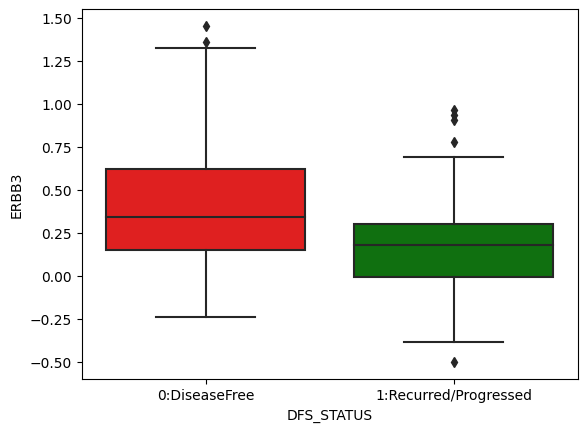

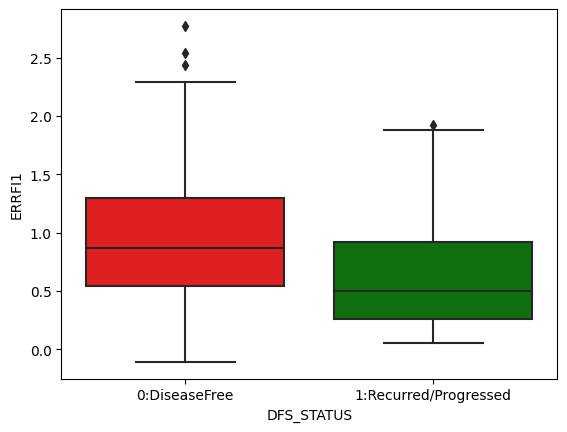

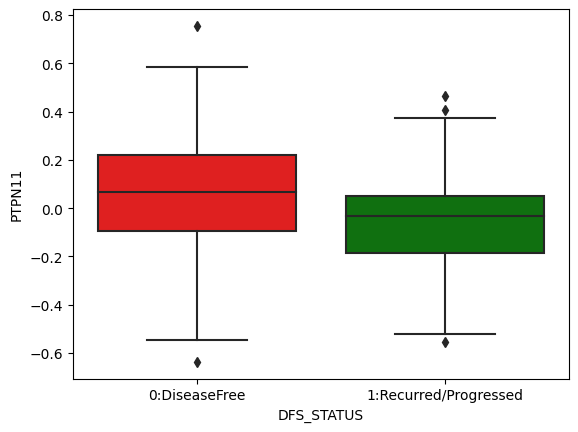

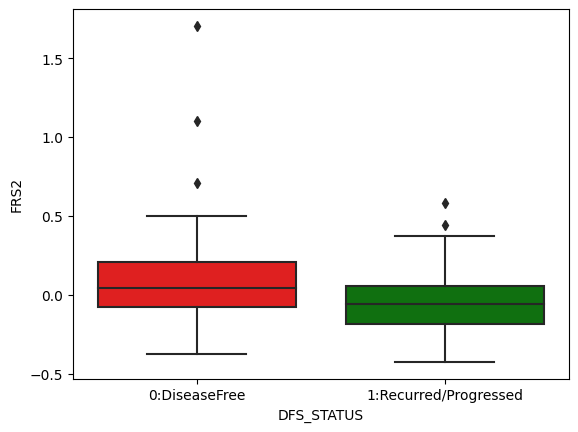

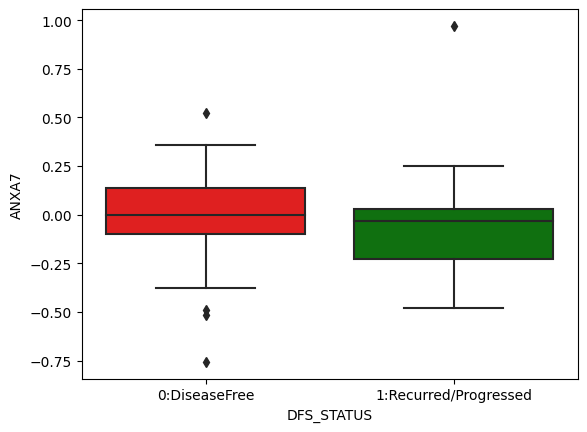

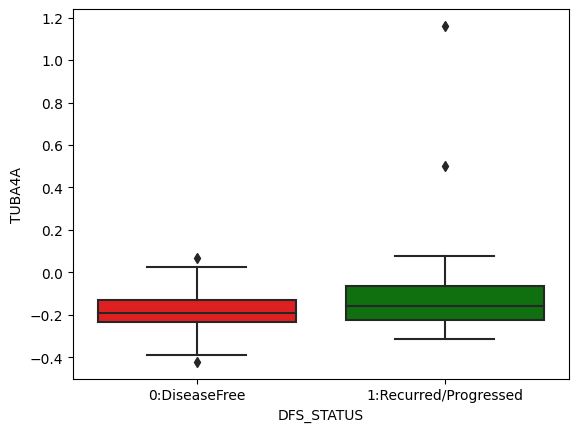

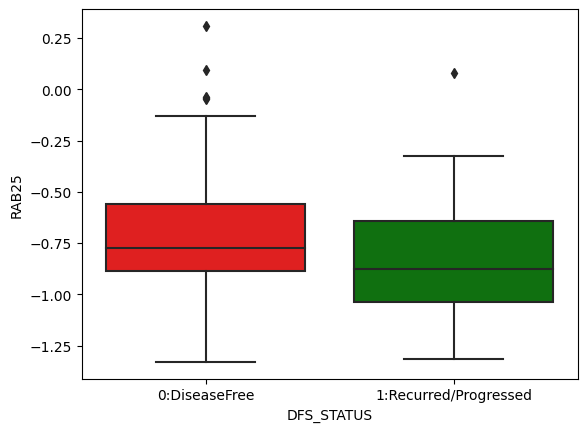

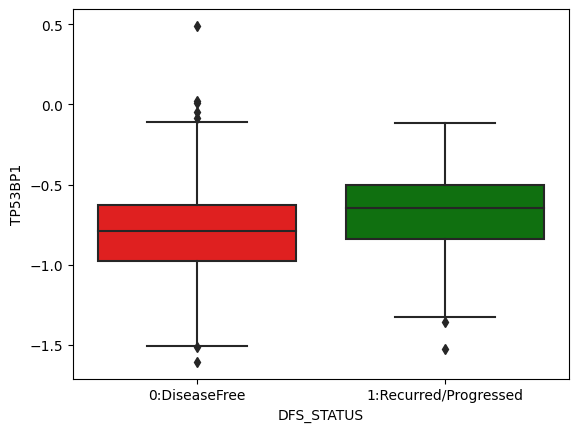

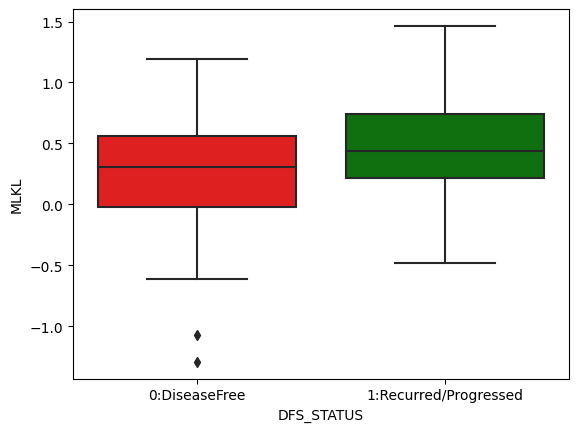

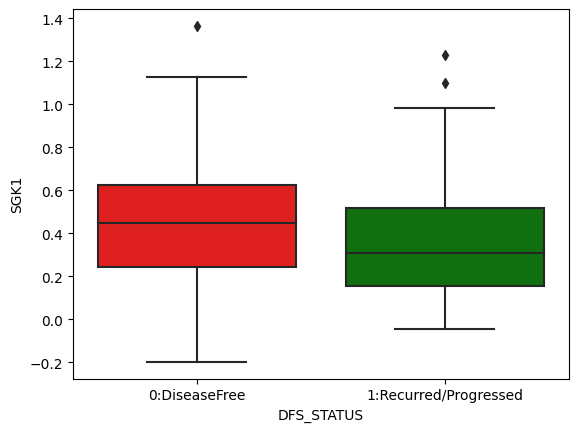

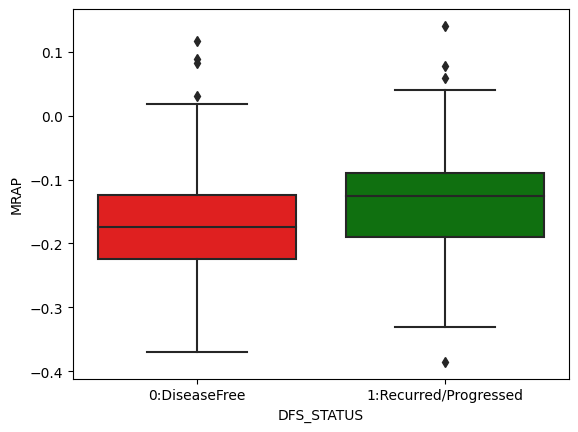

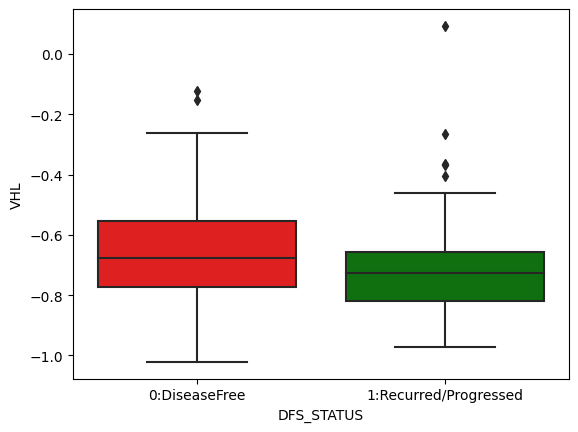

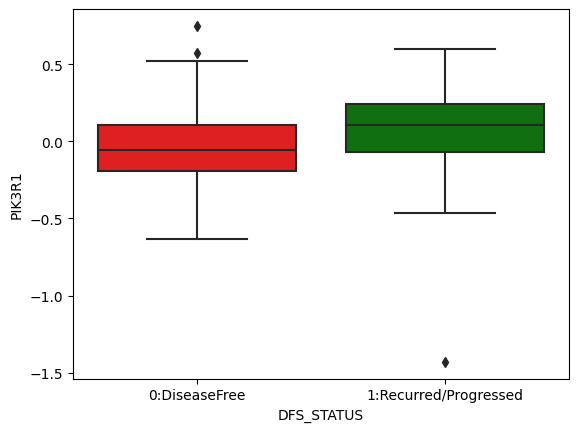

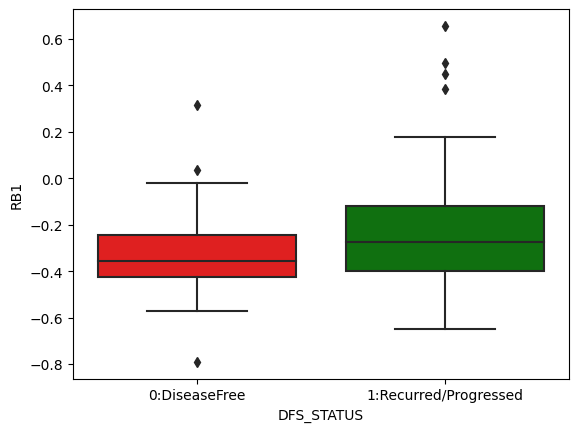

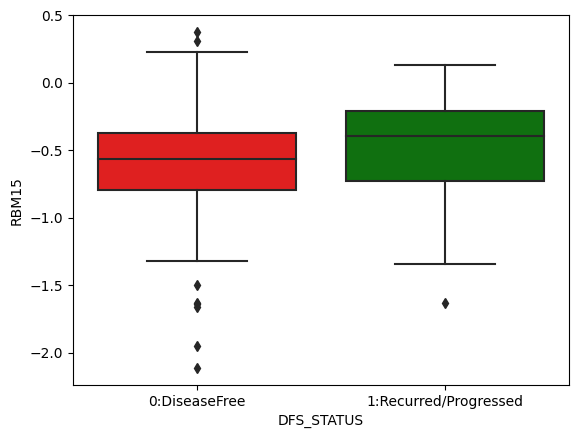

In [31]:
my_pal = {"0:DiseaseFree": "r", "1:Recurred/Progressed": "g"}
for prot in import_p.index:
    sns.boxplot(data=prot_total, x='DFS_STATUS', y=prot, palette=my_pal)
    plt.show()
    
